# 自动编码器基本概念 AutoEncoder


自动编码器(AutoEncoder)是神经网络的一种,一般来讲自动编码器包括两部分:编码器和解码器,编码器和解码器相互串联合作,实现数据的降维或特征学习,现在也广泛用于生成模型中.

下图为一个非常简单的自编码器结构图：

![](https://ai-studio-static-online.cdn.bcebos.com/ab12fc4a8aa74dcaaf46cae0656ef337c5a1c7a3a6714743bdca116096f5f971)

自编码神经网络是一种**无监督机器学习**算法，自动编码器训练的目的是将输入的图片经过神经网络之后再编码复原，可以看到只有两个全连接层就可以实现，左边是encoder，右边是decoder，下面我们来实现，并且实验。

**损失函数**
这里就用重构图像与原图像的欧式距离为损失函数好了

In [ ]:
#导入库
import paddle
import paddle.fluid as fluid
import numpy as np
import sys,os,math
import paddle.fluid.layers as F
import matplotlib.pylab as plt 
from PIL import Image

2020-08-31 15:31:54,565-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2020-08-31 15:31:54,912-INFO: generated new fontManager


In [ ]:
train_params = {
    'save_model_name':'Autoconder',
    'epoch_num':40000,
    'batch_size':32,
}

class AutoEncoder(fluid.dygraph.Layer):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = fluid.dygraph.Linear(784,128,act='sigmoid')
        self.decoder = fluid.dygraph.Linear(128,784,act='sigmoid')
    def loss(self,x,label):
        '''
        Args：
            label：原始图像
            x：解码之后的图像
        Return:
            原始图像和解码图像之间的欧式距离
        '''
        return F.square(x-label)

    def forward(self,x):
        self.input_imgs = x
        x = self.encoder(x)
        x = self.decoder(x)
        return x
def show_array2img(array,title):
    rebuilded_img = Image.fromarray(array.astype('uint8')).convert('RGB')
    plt.imshow(rebuilded_img)
    plt.title(title)
    plt.show()

def draw_train_process(iters,loss):
    '''
    训练可视化
    '''
    plt.title('training',fontsize=24)
    plt.xlabel('iters',fontsize=20)
    plt.ylabel('loss',fontsize=20)
    plt.plot(iters,loss,color='green',label='loss')
    plt.legend()
    plt.grid()
    plt.show()

def fix_value(img_pixs):#像素拉伸
        '''
        img_pixs:featuremap的像素矩阵
        '''
        pix_max=np.max(img_pixs)#取最大像素
        pix_min=np.min(img_pixs)#取最小像素
        pix_range=np.abs(pix_max)+np.abs(pix_min)#获取像素距离
        if(pix_range==0): #如果所有值都是零则直接返回（下面不能除以零）
            return img_pixs
        pix_rate = 255/pix_range#获取像素缩放倍率
        pix_left = pix_min*pix_rate#获取最小还原像素值
        img_pixs = img_pixs*pix_rate-pix_left#整体像素值平移
        img_pixs[np.where(img_pixs<0)]=0. #增加鲁棒性，检查超出区间的像素值，np.where(a<x)与a<x等同
        img_pixs[np.where(img_pixs>255)]=255.
        return img_pixs

with fluid.dygraph.guard():
    print('start training ')
    train_reader = paddle.batch(reader=paddle.reader.shuffle(\
        paddle.dataset.mnist.train(),buf_size=512),batch_size=train_params['batch_size'])  
    
    #读取一组32x784的输入，每次迭代都用这一个输入
    for i,data in enumerate(train_reader()):
        temp_images = []
        for i in range(32):
            temp_images.append(np.reshape(data[i][0],(784)))
        temp_images=fluid.dygraph.to_variable(np.asarray(temp_images).reshape((32,784)))
        temp_images= (temp_images+1)/2  #原来的数据区间是[-1,1]这里把它调整到[0,1]
        break
    model = AutoEncoder()  #实列化模型
    model.train()
    all_iter = 0
    all_loss = []
    all_iters = []
    all_accs = []
    opt=fluid.optimizer.AdamOptimizer(learning_rate=0.00001,parameter_list=model.parameters())
    for pass_num in range(train_params['epoch_num']):
        predict = model(temp_images)
        avg_loss= F.mean(model.loss(predict,temp_images))
        avg_loss.backward()
        opt.minimize(avg_loss)
        opt.clear_gradients()
        all_iter+=1
        if all_iter%5000==0:
            all_loss.append(avg_loss.numpy()[0])
            all_iters.append(all_iter)
            print('pass_epoch:{},iters:{},loss：{}'.format(pass_num,all_iter,avg_loss.numpy()[0]))
    fluid.save_dygraph(model.state_dict(),train_params['save_model_name']) #保存模型参数
    draw_train_process(all_iters,all_loss)
    predict = fix_value(predict.numpy())
    model.input_imgs = fix_value(model.input_imgs.numpy())
    print('finished training')
    #图像重构显示
    for i in range(10):
        show_array2img(np.reshape(model.input_imgs[i],(28,28)),'imput_img')
        show_array2img(np.asarray(np.reshape(predict[i],(28,28))),'rebuild_img')
   

# 自编码器训练结果
**这是经过40000次迭代之后的结果:上面是输入的图片下面是重构的图片**

![](https://ai-studio-static-online.cdn.bcebos.com/451e7b26c9df4ff980d1825253e67c8b2c4b5436994c433ba4d5fae67ffbed26)

# 自编码器的局限性

* 输入数据的区间[-1,1],为了更好地训练，这里我把它调整到[0,1]。
* 特征编码有限。由于这个自编码器的深度（或者说容量比较小），只能训练少量图片，所以每次迭代输入的图片都必须是同一组，否则网络不会收敛。
* 自动编码器是对数据的特征抽象和数据降维,因此需保证输入的数据具有一定的特征,即数据之间不是独立同分布的.如果每一个输入都是特征完全无关的,那么就会导致很难学习到特征.这也就是为啥每次输入要是同一组了。

**如果我们把隐藏层的特征维度降到2维，那么我们就可以把它们可视化在二维平面上，如下图。**

![](https://ai-studio-static-online.cdn.bcebos.com/97246bed9e724925ad1b205293f017801253e5b43c1b42f49f75cab8bfec437f)

**在这些点簇中**

* 颜色相同的为同一类别的特征点
* 同一颜色的点能很好的聚集成一簇，并且远离其他簇，表明特征提取较好（或者说有用）
* 同一颜色的点分散开来,混入其他不同颜色的点簇，那么这个特征抽象是失败的

下图是分类的比较好的点图，可以看到点簇是分开的。

![](https://ai-studio-static-online.cdn.bcebos.com/96ca4a8cb2074fc8a23703c023de093d033dad30310a44a883cf010f38a9d18f)



关于2维特征点图的绘制过程这里就不介绍了（下面会介绍3维的点图)


#  Stacked_AutoEncoder 堆栈自动编码器

堆栈式编码器（SEA)也叫做深度自动编码器，为啥深呢，因为它是简单的自编码器的叠加，增加了它的深度的同时，也增强了它的特征提取能力

* 因为有更深的层，所以我们可以用它来提取比自编码器更多的数据，在下面的训练中我们输入不再是少量样本，而是全部样本。

如下图所示，是一个5层的自动编码器，拥有两个Encoder和两个Decoder：

![](https://ai-studio-static-online.cdn.bcebos.com/1161b9b4c7634b3a9d9882df18cbb8d1921eb5e304fb49c58a5224a0219c9a06)

我们可以看到，编码器和解码器层数一样并且左右对称.




# 堆栈式自编码器的训练

对于我们上个自编码器，我们已经知道了容易进入局部最小化这个弊端，那么对于更深的堆栈式自编码器，我们应该如何训练呢。

* 这里我们有一种逐层贪婪训练的方法，这是一种十分经典的方法，它可以减缓深层网络出现梯度消失或者梯度爆炸问题。

* 在我们这个实验中，逐层训练的优势在于能在多样本的情况下更好地收敛。

**逐层训练的模式：**

* 我们先定义四个自编码器，最后一个用于把特征抽象映射到三维，我们可以把特征提取的结果显示在3D点云上。


In [ ]:
train_params = {
    'save_model_name':'S_Autoconder',
    'epoch_num':20,
    'batch_size':32,
    'step_training':True,#是否逐层训练
    'continue training':False,
}

class AutoEncoder(fluid.dygraph.Layer):
    '''
    自编码器:
    Args:
        route:路由，决定输入经过encode还是decoder
    '''
    def __init__(self,input_dim,hidden_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = fluid.dygraph.Linear(input_dim,hidden_dim,act='sigmoid',bias_attr=False)
        self.decocer = fluid.dygraph.Linear(hidden_dim,input_dim,act='sigmoid',bias_attr=False)
    def forward(self,x,route='ed'):
        if route =='e':     
            x = self.encoder(x)
        if route =='d':
            x = self.decocer(x)
        if route =='ed':
            x = self.encoder(x)
            x = self.decocer(x)    
        return x


class Stack_AutoEncoder(fluid.dygraph.Layer):
    '''
    堆栈式自编码器
    由若干个自编码器组成
    '''
    def __init__(self):
        super(Stack_AutoEncoder, self).__init__()
        self.AE0 = AutoEncoder(784,1000)
        self.AE1 = AutoEncoder(1000,500)
        self.AE2 = AutoEncoder(500,250)
        self.AE3 = AutoEncoder(250,3)

    def loss(self,x,label):
        '''
        Args：
            label：原始图像
            x：解码之后的图像
        Return:
            原始图像和解码图像之间的欧式距离
        '''
        return F.square(x-label)

    def forward(self,x,rote_list):
        '''
        Args：
            x：输入的图像
            rote_list:路由列表，'e'：输入只经过encoder,'d':只经过decode,'ed'：同时经过decode和encoder向前传播
        '''
        self.input_imgs = x
        x = self.AE0(x,rote_list[0])
        x = self.AE1(x,rote_list[1])
        x = self.AE2(x,rote_list[2])
        x = self.AE3(x,rote_list[3])
        if rote_list[-1]:
            return x
        x = self.AE2(x,rote_list[4])
        x = self.AE1(x,rote_list[5])
        x = self.AE0(x,rote_list[6])
        return x

然后我们需要拟定一个路由，使它能够逐层训练：
* 训练第一层的时候，使输入数据只通过最外层路由的encoder和decoder，并且只优化最外层的自编码器的参数。
* 训练第二层的时候，使输入数据通过外层自编码器，和这个编码器，并且只优化这个编码器的参数，其他参数不优化。

以此类推……直到训练完最后一个路由。


In [ ]:



def show_array2img(array,title):
    rebuilded_img = Image.fromarray(array.astype('uint8')).convert('RGB')
    plt.imshow(rebuilded_img)
    plt.title(title)
    plt.show()


def draw_train_process(iters,loss):
    '''
    训练可视化
    '''
    plt.title('training',fontsize=24)
    plt.xlabel('iters',fontsize=20)
    plt.ylabel('loss',fontsize=20)
    plt.plot(iters,loss,color='green',label='loss')
    plt.legend()
    plt.grid()
    plt.show()

def fix_value(img_pixs):#像素拉伸
        '''
        img_pixs:featuremap的像素矩阵
        '''
        pix_max=np.max(img_pixs)#取最大像素
        pix_min=np.min(img_pixs)#取最小像素
        pix_range=np.abs(pix_max)+np.abs(pix_min)#获取像素距离
        if(pix_range==0): #如果所有值都是零则直接返回（下面不能除以零）
            return img_pixs
        pix_rate = 255/pix_range#获取像素缩放倍率
        pix_left = pix_min*pix_rate#获取最小还原像素值
        img_pixs = img_pixs*pix_rate-pix_left#整体像素值平移
        img_pixs[np.where(img_pixs<0)]=0. #增加鲁棒性，检查超出区间的像素值，np.where(a<x)与a<x等同
        img_pixs[np.where(img_pixs>255)]=255.
        return img_pixs

with fluid.dygraph.guard():
    print('start training ')
    train_reader = paddle.batch(reader=paddle.reader.shuffle(\
        paddle.dataset.mnist.train(),buf_size=512),batch_size=train_params['batch_size'])  
    for i,data in enumerate(train_reader()):
        temp_images = []
        for i in range(32):
            temp_images.append(np.reshape(data[i][0],(784)))
        temp_images=fluid.dygraph.to_variable(np.asarray(temp_images).reshape((32,784)))
        temp_images= (temp_images+1)/2
        break
    model = Stack_AutoEncoder()  #实列化模型
    if os.path.exists(train_params['save_model_name'] + '.pdparams') and train_params['continue training']:#存在模型参数则继续训练
        print('continue training')
        param_dict,_ = fluid.dygraph.load_dygraph(train_params['save_model_name'])
        model.load_dict(param_dict)
    model.train()
    all_iter = 0
    all_loss = []
    all_iters = []
    all_accs = []
    rote_list = ['e','e','e','ed','d','d','d',False]#路由列表
    check_point = train_params['epoch_num']/10
    opt = fluid.optimizer.AdamOptimizer(learning_rate=0.001,parameter_list=model.parameters())
    for pass_num in range(train_params['epoch_num']): 
        if train_params['step_training']:
                if pass_num == 0:
                    print('训练AE0')
                    opt.parameter_list=model.AE0.parameters()
                    rote_list = ['ed','n','n','n','n','n','n',False]
                if pass_num == check_point:
                    print('训练AE1')
                    opt.parameter_list=model.AE1.parameters()
                    rote_list = ['e','ed','n','n','n','n','d',False]
                if pass_num == check_point*2:
                    print('训练AE2')
                    opt.parameter_list=model.AE2.parameters()
                    rote_list = ['e','e','ed','n','n','d','d',False]
                if pass_num == check_point*3:
                    print('训练AE3')
                    opt.parameter_list=model.AE3.parameters()
                    rote_list = ['e','e','e','ed','d','d','d',False]
        for i,data in enumerate(train_reader()):
            temp_images = []
            for i in range(32):
                temp_images.append(np.reshape(data[i][0],(784)))
            temp_images=fluid.dygraph.to_variable(np.asarray(temp_images).reshape((32,784)))
            temp_images= (temp_images+1)/2
            predict = model(temp_images,rote_list)
            avg_loss= F.mean(model.loss(predict,temp_images))
            avg_loss.backward()
            opt.minimize(avg_loss)
            opt.clear_gradients()
            all_iter+=1
            if all_iter%500==0:
                all_loss.append(avg_loss.numpy()[0])
                all_iters.append(all_iter)
                print('pass_epoch:{},iters:{},loss：{}'.format(pass_num,all_iter,avg_loss.numpy()[0]))
    fluid.save_dygraph(model.state_dict(),train_params['save_model_name']) #保存模型参数
    draw_train_process(all_iters,all_loss)
    predict = fix_value(predict.numpy())
    model.input_imgs = fix_value(model.input_imgs.numpy())
    print('finished training')
    #decoder图像显示
    for i in range(32):
        show_array2img(np.reshape(model.input_imgs[i],(28,28)),'imput_img')
        show_array2img(np.asarray(np.reshape(predict[i],(28,28))),'rebuild_img')
   

# 逐层训练效果

这里我们对先对浅层的编码器进行训练，后对深层的编码器进行训练，最后的编码器我们用于特征进行映射到3维，把特征提取的结果显示在3d点云上。

* 我们可以看到逐层训练浅层的特征编码效果非常好（loss小于0.01），并且对下一层的收敛起到了很不错的效果
* 深层的编码的损失最终下降到了0.03
* 把特征映射到3维点云之后可以看到分散而开每一类都形成了一团点簇
* 所有的点仅仅弥散在0.6 x 0.6 x 0.6的空间里

![](https://ai-studio-static-online.cdn.bcebos.com/4505435c91dc4cb0970cdcd93286508b22a9aa74941e4e2f987d47a6a6ebb826)


# 非逐层训练效果

在同样轮数和学习率的情况下我进行非逐层训练的结果：

![](https://ai-studio-static-online.cdn.bcebos.com/9e196cea5ddf4aefa6623871c0c2b4885b309197e2924f0d910f74b980acb310)

* 可以看到没有使用逐层训练的情况就差多了，loss下降到0.04后就原地踏步
* 解码效果也远远不如逐层训练来的好，网络对于4,7,9等几个数组的解码有时候是混乱的。
* 把特征映射到点云之后没有看到团簇，只能看到所有点全部密集的挤在一条线上。
* 所有点弥散在1 x 1 x 1 的空间里 比 逐步训练的大了许多


# 3D点云绘制

* 加载模型，加载参数
* 配置数据读取器，每次只读一张图
* 创建字典，存放每类映射的特征
* 配置路由，网络输出3维特征
* 进行迭代，获得3维特征append对应类到list
* 调用绘制函数绘制。

![](https://ai-studio-static-online.cdn.bcebos.com/85191469b18e4e759ac99fea3d7440aa7fb11603f9f4458eb69ea2a2a093d806)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def draw3dcolud(data):
    fig=plt.figure(dpi=120)
    ax=fig.add_subplot(111,projection='3d')
    plt.title('point cloud')
    #为不同类别的点云使用不同颜色
    dr_numbers_color={
        '0':'blue',
        '1':'red',
        '2':'green',
        '3':'yellow',
        '4':'pink',
        '5':'cyan',
        '6':'brown',
        '7':'orange',
        '8':'limegreen',
        '9':'blueviolet'
    }
    #绘制点云
    for k,v in data.items():
        #获取将三维向量每个分量作为xyz坐标值
        x=v[:,0]
        y=v[:,1]
        z=v[:,2]
        ax.scatter(x,y,z,#xyz坐标值
                c=dr_numbers_color[k],#颜色
                marker='.',
                s=2,
                linewidth=0,
                alpha=1,
                cmap='spectral')
    ax.axis('scaled')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()


with fluid.dygraph.guard():
    #读取模型参数
    param_dict,_ = fluid.dygraph.load_dygraph(train_params['save_model_name'])
    #数据读取器,这里我们每次只读取一张
    train_reader = paddle.batch(reader=paddle.dataset.mnist.train(),batch_size=1) 
    model = Stack_AutoEncoder()
    model.load_dict(param_dict)
    model.eval()
    dr_numbers={#存放10个数字对应的列表
        '0':[],
        '1':[],
        '2':[],
        '3':[],
        '4':[],
        '5':[],
        '6':[],
        '7':[],
        '8':[],
        '9':[]
    }
    rote_list = ['e','e','e','e','d','d','d',True]#路由列表
    for pass_num in range(1):
        for batch_id,data in enumerate(train_reader()):
            temp_images=fluid.dygraph.to_variable(np.asarray(data[0][0]).reshape((1,784)))
            predict = model(temp_images,rote_list)
            dr_numbers[str(data[0][1])].append(predict)
    for k,v in dr_numbers.items():
        dr_numbers[k] = F.concat(v,axis=0).numpy()
    draw3dcolud(dr_numbers)

# 降噪自编码器 Denoising Autoencoder

堆栈式自编码器层数多，可能会出现另外一种情况：编码器并没有提取特征，解码器正好是对解码器的复原。

这种情况下对挖掘特征就没任何意义。

为了解决这个问题，我们可以向输入中添加噪声，让自编码器通过抗噪声过程增强其特征提取能力。

**于是我们将在自编码器中添加噪声（下面代码中第59-61）**

下面我们来试试叭

In [ ]:
train_params = {
    'save_model_name':'S_Autoconder',
    'epoch_num':20,
    'batch_size':32,
    'step_training':True,#是否逐层训练
    'continue training':False,
}

class AutoEncoder(fluid.dygraph.Layer):
    '''
    自编码器:
    Args:
        route:路由，决定输入经过encode还是decoder
    '''
    def __init__(self,input_dim,hidden_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = fluid.dygraph.Linear(input_dim,hidden_dim,act='sigmoid',bias_attr=False)
        self.decocer = fluid.dygraph.Linear(hidden_dim,input_dim,act='sigmoid',bias_attr=False)
    def forward(self,x,route='ed'):
        if route =='e':     
            x = self.encoder(x)
        if route =='d':
            x = self.decocer(x)
        if route =='ed':
            x = self.encoder(x)
            x = self.decocer(x)    
        return x


class Stack_AutoEncoder(fluid.dygraph.Layer):
    '''
    堆栈式自编码器
    由若干个自编码器组成
    '''
    def __init__(self):
        super(Stack_AutoEncoder, self).__init__()
        self.AE0 = AutoEncoder(784,1000)
        self.AE1 = AutoEncoder(1000,500)
        self.AE2 = AutoEncoder(500,250)
        self.AE3 = AutoEncoder(250,3)

    def loss(self,x,label):
        '''
        Args：
            label：原始图像
            x：解码之后的图像
        Return:
            原始图像和解码图像之间的欧式距离
        '''
        return F.square(x-label)

    def forward(self,x,rote_list):
        '''
        Args：
            x：输入的图像
            rote_list:路由列表，'e'：输入只经过encoder,'d':只经过decode,'ed'：同时经过decode和encoder向前传播
        '''
        self.input_imgs = x
        if not rote_list[-1]:#如果是训练模式就加入噪声
            noise = fluid.dygraph.to_variable(np.random.uniform(0,1,size=x.shape)).astype('float32')
            x+=noise
        x = self.AE0(x,rote_list[0])
        x = self.AE1(x,rote_list[1])
        x = self.AE2(x,rote_list[2])
        x = self.AE3(x,rote_list[3])
        if rote_list[-1]:
            return x
        x = self.AE2(x,rote_list[4])
        x = self.AE1(x,rote_list[5])
        x = self.AE0(x,rote_list[6])
        return x




def show_array2img(array,title):
    rebuilded_img = Image.fromarray(array.astype('uint8')).convert('RGB')
    plt.imshow(rebuilded_img)
    plt.title(title)
    plt.show()


def draw_train_process(iters,loss):
    '''
    训练可视化
    '''
    plt.title('training',fontsize=24)
    plt.xlabel('iters',fontsize=20)
    plt.ylabel('loss',fontsize=20)
    plt.plot(iters,loss,color='green',label='loss')
    plt.legend()
    plt.grid()
    plt.show()

def fix_value(img_pixs):#像素拉伸
        '''
        img_pixs:featuremap的像素矩阵
        '''
        pix_max=np.max(img_pixs)#取最大像素
        pix_min=np.min(img_pixs)#取最小像素
        pix_range=np.abs(pix_max)+np.abs(pix_min)#获取像素距离
        if(pix_range==0): #如果所有值都是零则直接返回（下面不能除以零）
            return img_pixs
        pix_rate = 255/pix_range#获取像素缩放倍率
        pix_left = pix_min*pix_rate#获取最小还原像素值
        img_pixs = img_pixs*pix_rate-pix_left#整体像素值平移
        img_pixs[np.where(img_pixs<0)]=0. #增加鲁棒性，检查超出区间的像素值，np.where(a<x)与a<x等同
        img_pixs[np.where(img_pixs>255)]=255.
        return img_pixs

with fluid.dygraph.guard():
    print('start training ')
    train_reader = paddle.batch(reader=paddle.reader.shuffle(\
        paddle.dataset.mnist.train(),buf_size=512),batch_size=train_params['batch_size'])  
    for i,data in enumerate(train_reader()):
        temp_images = []
        for i in range(32):
            temp_images.append(np.reshape(data[i][0],(784)))
        temp_images=fluid.dygraph.to_variable(np.asarray(temp_images).reshape((32,784)))
        temp_images= (temp_images+1)/2
        break
    model = Stack_AutoEncoder()  #实列化模型
    if os.path.exists(train_params['save_model_name'] + '.pdparams') and train_params['continue training']:#存在模型参数则继续训练
        print('continue training')
        param_dict,_ = fluid.dygraph.load_dygraph(train_params['save_model_name'])
        model.load_dict(param_dict)
    model.train()
    all_iter = 0
    all_loss = []
    all_iters = []
    all_accs = []
    rote_list = ['e','e','e','ed','d','d','d',False]#路由列表
    check_point = train_params['epoch_num']/10
    opt = fluid.optimizer.AdamOptimizer(learning_rate=0.001,parameter_list=model.parameters())
    for pass_num in range(train_params['epoch_num']): 
        if train_params['step_training']:
                if pass_num == 0:
                    print('训练AE0')
                    opt.parameter_list=model.AE0.parameters()
                    rote_list = ['ed','n','n','n','n','n','n',False]
                if pass_num == check_point:
                    print('训练AE1')
                    opt.parameter_list=model.AE1.parameters()
                    rote_list = ['e','ed','n','n','n','n','d',False]
                if pass_num == check_point*2:
                    print('训练AE2')
                    opt.parameter_list=model.AE2.parameters()
                    rote_list = ['e','e','ed','n','n','d','d',False]
                if pass_num == check_point*3:
                    print('训练AE3')
                    opt.parameter_list=model.AE3.parameters()
                    rote_list = ['e','e','e','ed','d','d','d',False]
        for i,data in enumerate(train_reader()):
            temp_images = []
            for i in range(32):
                temp_images.append(np.reshape(data[i][0],(784)))
            temp_images=fluid.dygraph.to_variable(np.asarray(temp_images).reshape((32,784)))
            temp_images= (temp_images+1)/2
            predict = model(temp_images,rote_list)
            avg_loss= F.mean(model.loss(predict,temp_images))
            avg_loss.backward()
            opt.minimize(avg_loss)
            opt.clear_gradients()
            all_iter+=1
            if all_iter%500==0:
                all_loss.append(avg_loss.numpy()[0])
                all_iters.append(all_iter)
                print('pass_epoch:{},iters:{},loss：{}'.format(pass_num,all_iter,avg_loss.numpy()[0]))
    fluid.save_dygraph(model.state_dict(),train_params['save_model_name']) #保存模型参数
    draw_train_process(all_iters,all_loss)
    predict = fix_value(predict.numpy())
    model.input_imgs = fix_value(model.input_imgs.numpy())
    print('finished training')
    #decoder图像显示
    for i in range(32):
        show_array2img(np.reshape(model.input_imgs[i],(28,28)),'imput_img')
        show_array2img(np.asarray(np.reshape(predict[i],(28,28))),'rebuild_img')
   

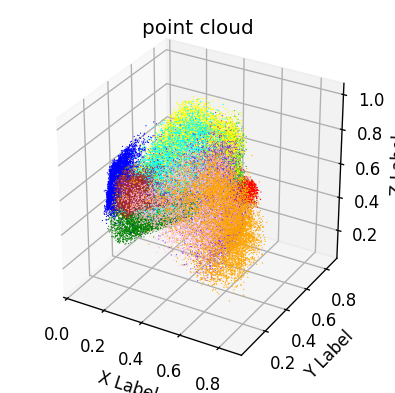

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def draw3dcolud(data):
    fig=plt.figure(dpi=120)
    ax=fig.add_subplot(111,projection='3d')
    plt.title('point cloud')
    #为不同类别的点云使用不同颜色
    dr_numbers_color={
        '0':'blue',
        '1':'red',
        '2':'green',
        '3':'yellow',
        '4':'pink',
        '5':'cyan',
        '6':'brown',
        '7':'orange',
        '8':'limegreen',
        '9':'blueviolet'
    }
    #绘制点云
    for k,v in data.items():
        #获取将三维向量每个分量作为xyz坐标值
        x=v[:,0]
        y=v[:,1]
        z=v[:,2]
        ax.scatter(x,y,z,#xyz坐标值
                c=dr_numbers_color[k],#颜色
                marker='.',
                s=2,
                linewidth=0,
                alpha=1,
                cmap='spectral')
    ax.axis('scaled')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()


with fluid.dygraph.guard():
    #读取模型参数
    param_dict,_ = fluid.dygraph.load_dygraph(train_params['save_model_name'])
    #数据读取器,这里我们每次只读取一张
    train_reader = paddle.batch(reader=paddle.dataset.mnist.train(),batch_size=1) 
    model = Stack_AutoEncoder()
    model.load_dict(param_dict)
    model.eval()
    dr_numbers={#存放10个数字对应的列表
        '0':[],
        '1':[],
        '2':[],
        '3':[],
        '4':[],
        '5':[],
        '6':[],
        '7':[],
        '8':[],
        '9':[]
    }
    rote_list = ['e','e','e','e','d','d','d',True]#路由列表
    for pass_num in range(1):
        for batch_id,data in enumerate(train_reader()):
            temp_images=fluid.dygraph.to_variable(np.asarray(data[0][0]).reshape((1,784)))
            predict = model(temp_images,rote_list)
            dr_numbers[str(data[0][1])].append(predict)
    for k,v in dr_numbers.items():
        dr_numbers[k] = F.concat(v,axis=0).numpy()
    draw3dcolud(dr_numbers)

# 降噪堆叠自编码器总结

* 添加了噪声后的编码器仍然能很好地解码了图像
* 从点状云中可以看出各个类的点簇分布地更加明显了，证明特征提取更强了

![](https://ai-studio-static-online.cdn.bcebos.com/2eff2a5ae8084b97a8ad846f070b52617f7867e0b1224ce7a3319a8c1433289d)



# 稀疏自编码器 Sparse Autoencoder

* 如果自编码器的隐藏节点如果小于输入节点，那么自编码器在训练过程中学习到的更加可能是输入数据的内部规律，这很类似PCA，得到的是输入数据的一个降维表示。

* 那么我们设定隐藏节点数大于输入节点数，比如输入是784，下个隐藏节点是1000，那么这1000个节点有可能是都激活，即神经元输出都是1,（这里讨论sigmoid作为激活函数的情况下），同时也有可能是很少的神经元被激活，比如大部分输出都接近于0 只有少部分输出接近1，这些情况都可能会影响神经元提取特征效果。

* 为了解决上面这个问题，我们给自编码器加上一个稀疏限制，使神经元节点在训练过程中同时只能激活一定数量的节点，这样就成了稀疏自编码器。

* 为了达到这个目的，我们引入了KL离散度来衡量某个隐层节点的平均激活输出和我们设定的稀疏度ρ之间的相似性： 

![](https://ai-studio-static-online.cdn.bcebos.com/34497fed594d4f588601579e366779e01cb29c653d924e09b9080758ee4f9250)


* 公式中 ρ^j 为隐藏节点j对所有样本的响应输出，一般来说我们设定稀疏系数ρ=0.05或0.1。KL离散度越大代表ρ和ρ^j之间相差越大，KL离散度等于0代表两者完全相等ρ=ρ^j。 
* 现在，我们将KL离散度作为正则项加入到损失函数中，以此对整个堆栈自编码器网络的稀疏行进行约束：

![](https://ai-studio-static-online.cdn.bcebos.com/c07fb6e30e78464cb6a1cfc21d93e7d2a846723799454c0fb9d3b2341017bb7e)




In [ ]:
#kl 散度损失实现
def KL_loss(rho,rho_hat):
    '''
    Args:
        rho:公式中的ρ 值设定为0.05
        rho_hat：shape=[hidden_dim] 隐藏节点输出，对batch_size求了均值
    Return：
        kl_loss.
    '''
    rho_arr = np.ones_like(rho_hat.shape[:]).astype('float32')
    rho = fluid.dygraph.to_variable(rho_arr*rho)
    term_num = 1.0 - rho
    term_den = 1.0 - rho_hat
    kl = log_fun(rho,rho_hat)+log_fun(term_num,term_den)
    return kl

def log_fun(x,y):
    return F.elementwise_mul(x,(F.elementwise_div(x,y)))

接下来我们开始愉快地炼丹叭

见代码 26 44-54 140-159

start training 
训练AE0
pass_epoch:0,iters:500,loss：0.049017518758773804
pass_epoch:0,iters:1000,loss：0.03865252435207367
pass_epoch:0,iters:1500,loss：0.03368198871612549
pass_epoch:1,iters:2000,loss：0.03496941924095154
pass_epoch:1,iters:2500,loss：0.030681638047099113
pass_epoch:1,iters:3000,loss：0.028130821883678436
pass_epoch:1,iters:3500,loss：0.025150690227746964
pass_epoch:2,iters:4000,loss：0.02749450132250786
pass_epoch:2,iters:4500,loss：0.025759756565093994
pass_epoch:2,iters:5000,loss：0.024320628494024277
pass_epoch:2,iters:5500,loss：0.023526662960648537
pass_epoch:3,iters:6000,loss：0.024195335805416107
pass_epoch:3,iters:6500,loss：0.023674771189689636
pass_epoch:3,iters:7000,loss：0.02268652431666851
pass_epoch:3,iters:7500,loss：0.023429911583662033
finished trained AE0 KL_LOSS:[0.01178009]
训练AE1
pass_epoch:4,iters:8000,loss：0.03714932128787041
pass_epoch:4,iters:8500,loss：0.03330612927675247
pass_epoch:4,iters:9000,loss：0.03147798031568527
pass_epoch:5,iters:9500,loss：0.02722875

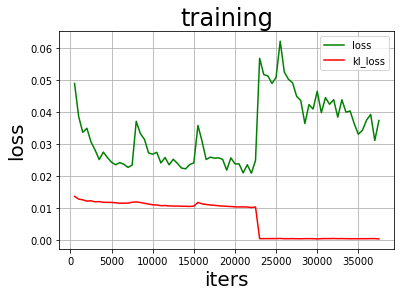

finished training


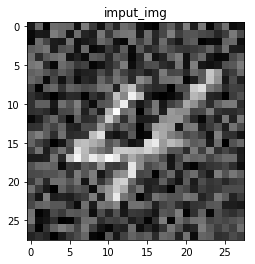

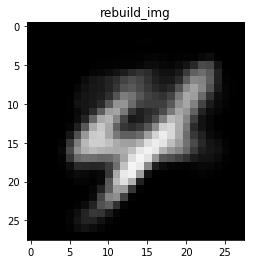

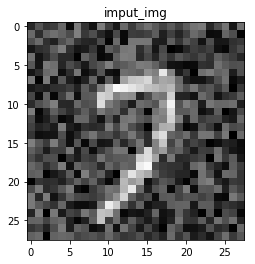

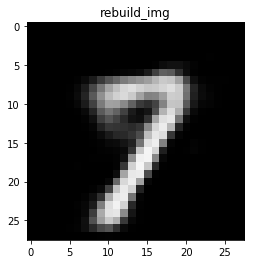

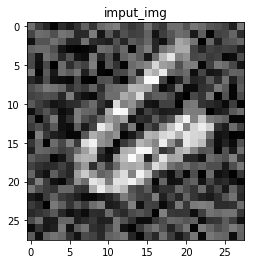

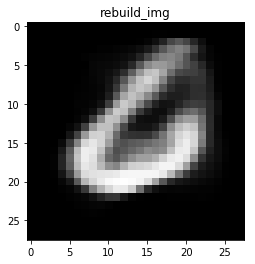

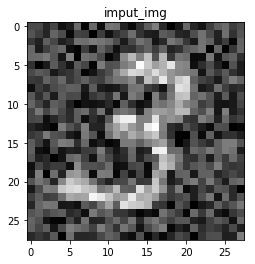

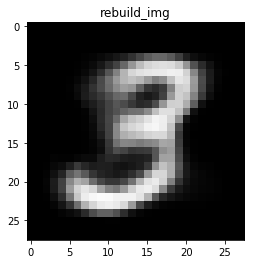

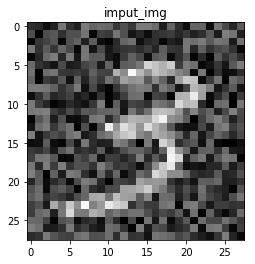

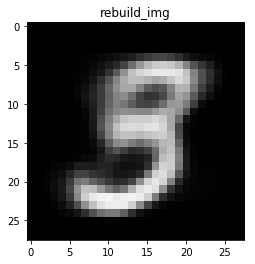

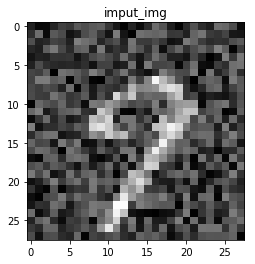

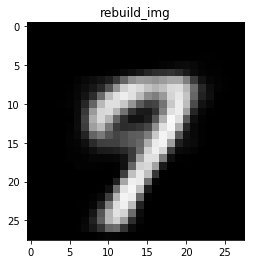

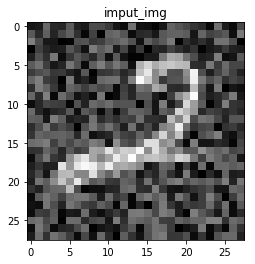

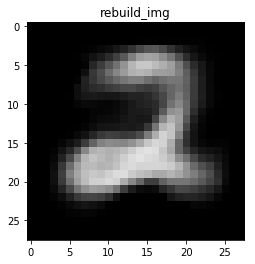

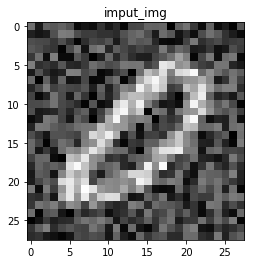

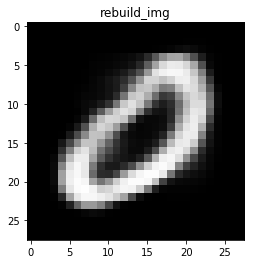

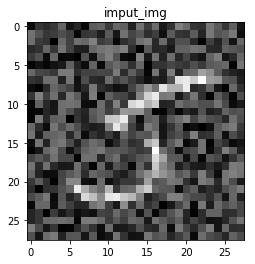

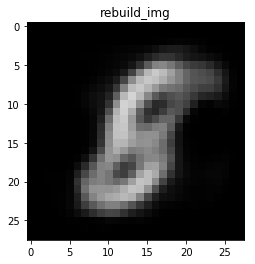

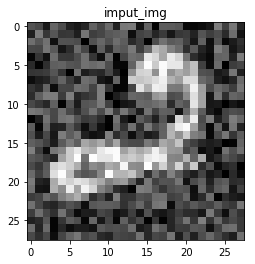

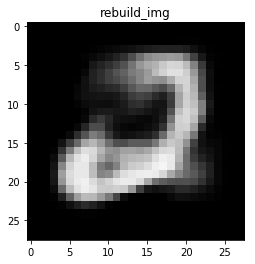

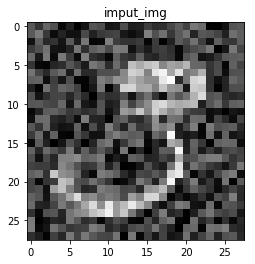

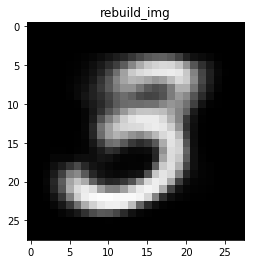

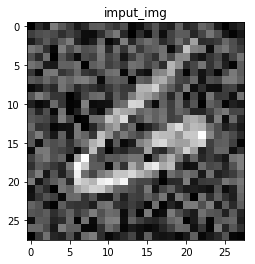

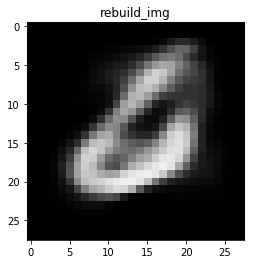

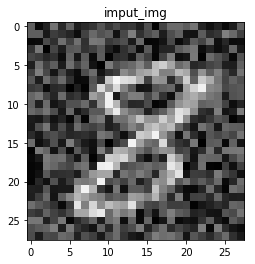

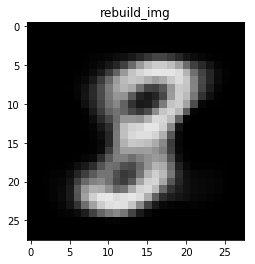

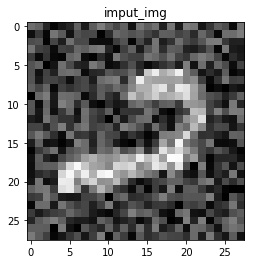

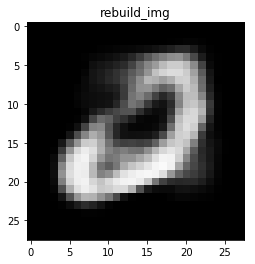

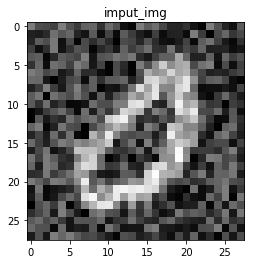

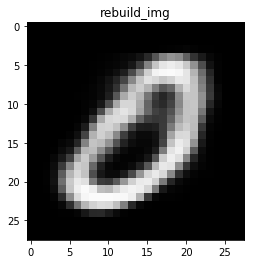

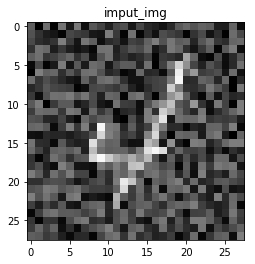

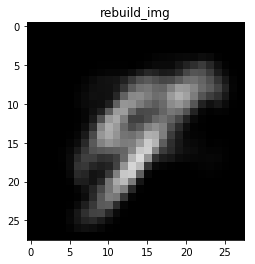

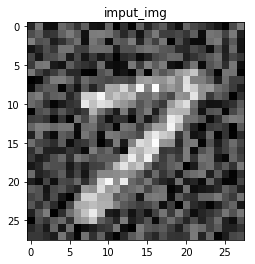

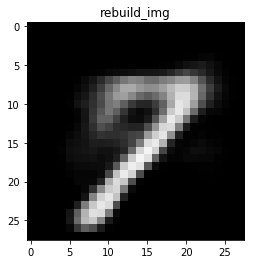

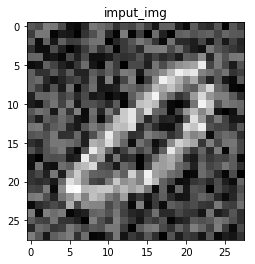

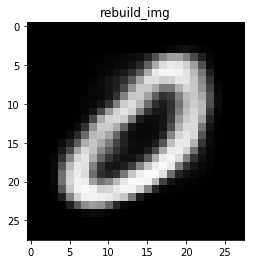

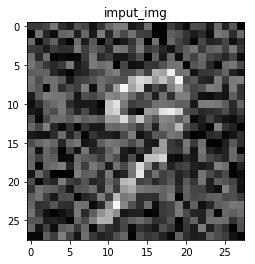

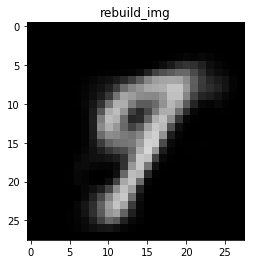

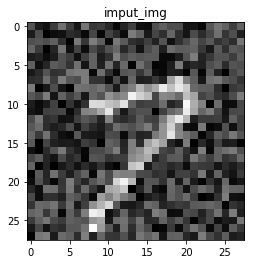

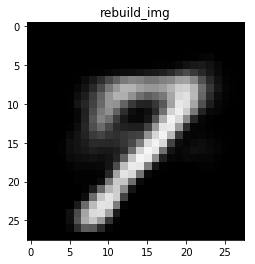

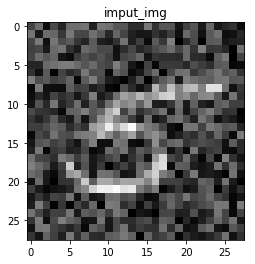

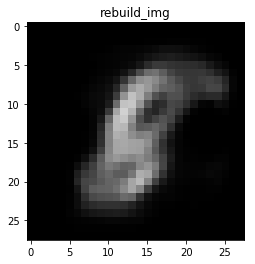

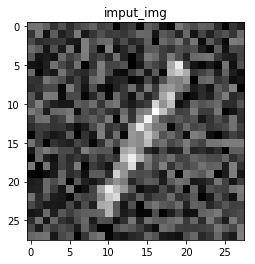

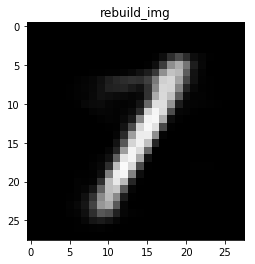

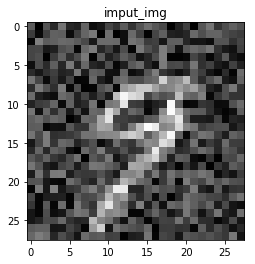

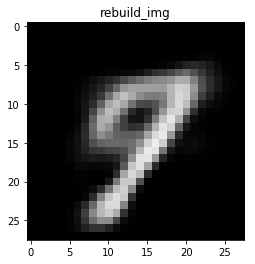

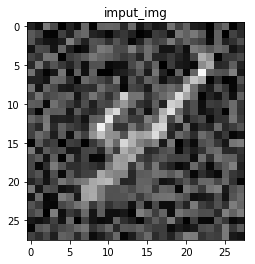

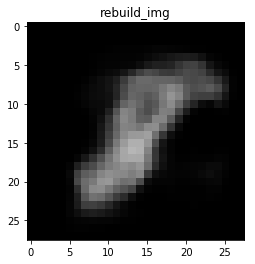

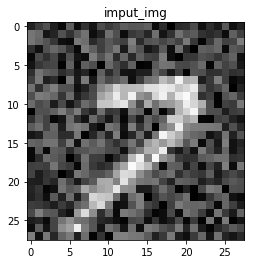

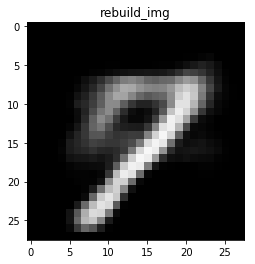

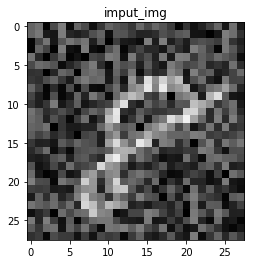

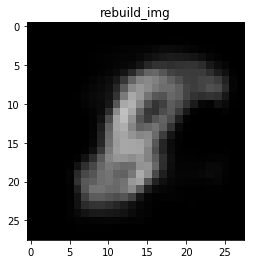

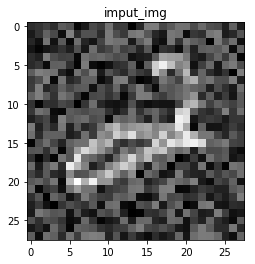

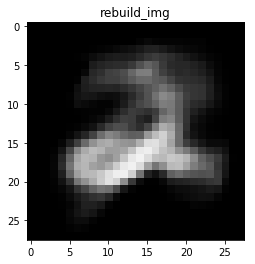

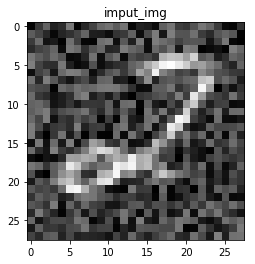

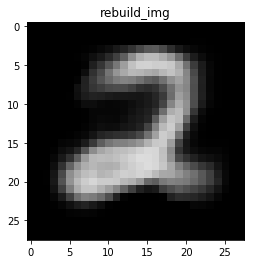

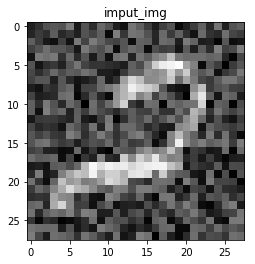

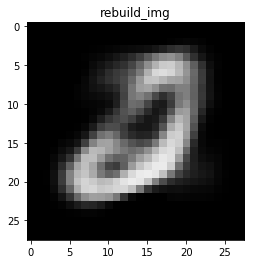

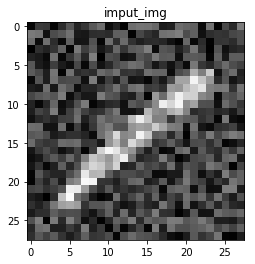

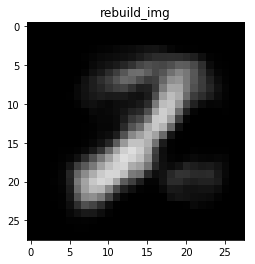

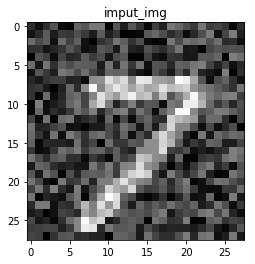

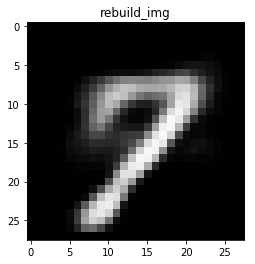

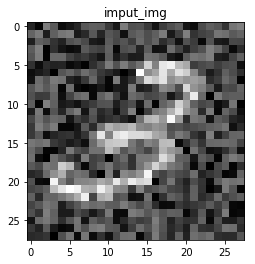

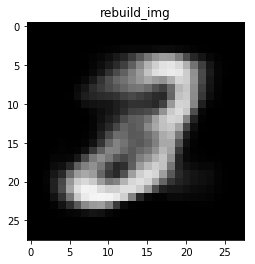

In [29]:
train_params = {
    'save_model_name':'S_Autoconder',
    'epoch_num':20,
    'batch_size':32,
    'step_training':True,#是否逐层训练
    'continue training':False,
}

class AutoEncoder(fluid.dygraph.Layer):
    '''
    自编码器:
    Args:
        route:路由，决定输入经过encode还是decoder
    '''
    def __init__(self,input_dim,hidden_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = fluid.dygraph.Linear(input_dim,hidden_dim,act='sigmoid',bias_attr=False)
        self.decocer = fluid.dygraph.Linear(hidden_dim,input_dim,act='sigmoid',bias_attr=False)
    def forward(self,x,route='ed'):
        if route =='e':     
            x = self.encoder(x)
        if route =='d':
            x = self.decocer(x)
        if route =='ed':
            x = self.encoder(x)
            self.kl_loss = F.reduce_sum(KL_loss(0.05,F.reduce_mean(x,dim=0)))*7.5e-5
            x = self.decocer(x)
            return x   
        return x


class Stack_AutoEncoder(fluid.dygraph.Layer):
    '''
    堆栈式自编码器
    由若干个自编码器组成
    '''
    def __init__(self):
        super(Stack_AutoEncoder, self).__init__()
        self.AE0 = AutoEncoder(784,128)
        self.AE1 = AutoEncoder(128,128)
        self.AE2 = AutoEncoder(128,128)
        self.AE3 = AutoEncoder(128,3)

    def loss(self,x,label,rote_list):
        '''
        Args：
            label：原始图像
            x：解码之后的图像
        Return:
            原始图像和解码图像之间的欧式距离
        '''
        index = rote_list.index('ed')
        total_kl_loss = getattr(self,'AE'+str(index)).kl_loss
        return F.square(x-label)+total_kl_loss,total_kl_loss

    def forward(self,x,rote_list):
        '''
        Args：
            x：输入的图像
            rote_list:路由列表，'e'：输入只经过encoder,'d':只经过decode,'ed'：同时经过decode和encoder向前传播
        '''
        self.input_imgs = x
        if not rote_list[-1]:#如果是训练模式就加入噪声
            noise = fluid.dygraph.to_variable(np.random.uniform(0,1,size=x.shape)).astype('float32')
            x+=noise
            self.noise_img = x
        x = self.AE0(x,rote_list[0])
        x = self.AE1(x,rote_list[1])
        x = self.AE2(x,rote_list[2])
        x = self.AE3(x,rote_list[3])
        if rote_list[-1]:
            return x
        x = self.AE2(x,rote_list[4])
        x = self.AE1(x,rote_list[5])
        x = self.AE0(x,rote_list[6])
        return x




def show_array2img(array,title):
    rebuilded_img = Image.fromarray(array.astype('uint8')).convert('RGB')
    plt.imshow(rebuilded_img)
    plt.title(title)
    plt.show()


def draw_train_process(iters,loss,all_klloss):
    '''
    训练可视化
    '''
    plt.title('training',fontsize=24)
    plt.xlabel('iters',fontsize=20)
    plt.ylabel('loss',fontsize=20)
    plt.plot(iters,loss,color='green',label='loss')
    plt.plot(iters,all_klloss,color='red',label='kl_loss')
    plt.legend()
    plt.grid()
    plt.show()

def fix_value(img_pixs):#像素拉伸
        '''
        img_pixs:featuremap的像素矩阵
        '''
        pix_max=np.max(img_pixs)#取最大像素
        pix_min=np.min(img_pixs)#取最小像素
        pix_range=np.abs(pix_max)+np.abs(pix_min)#获取像素距离
        if(pix_range==0): #如果所有值都是零则直接返回（下面不能除以零）
            return img_pixs
        pix_rate = 255/pix_range#获取像素缩放倍率
        pix_left = pix_min*pix_rate#获取最小还原像素值
        img_pixs = img_pixs*pix_rate-pix_left#整体像素值平移
        img_pixs[np.where(img_pixs<0)]=0. #增加鲁棒性，检查超出区间的像素值，np.where(a<x)与a<x等同
        img_pixs[np.where(img_pixs>255)]=255.
        return img_pixs

with fluid.dygraph.guard():
    print('start training ')
    train_reader = paddle.batch(reader=paddle.reader.shuffle(\
        paddle.dataset.mnist.train(),buf_size=512),batch_size=train_params['batch_size'])  
    for i,data in enumerate(train_reader()):
        temp_images = []
        for i in range(32):
            temp_images.append(np.reshape(data[i][0],(784)))
        temp_images=fluid.dygraph.to_variable(np.asarray(temp_images).reshape((32,784)))
        temp_images= (temp_images+1)/2
        break
    model = Stack_AutoEncoder()  #实列化模型
    if os.path.exists(train_params['save_model_name'] + '.pdparams') and train_params['continue training']:#存在模型参数则继续训练
        print('continue training')
        param_dict,_ = fluid.dygraph.load_dygraph(train_params['save_model_name'])
        model.load_dict(param_dict)
    model.train()
    all_iter = 0
    all_loss = []
    all_iters = []
    all_accs = []
    all_klloss = []
    rote_list = ['e','e','e','ed','d','d','d',False]#路由列表
    check_point = train_params['epoch_num']/10
    opt = fluid.optimizer.AdamOptimizer(learning_rate=0.001,parameter_list=model.parameters())
    for pass_num in range(train_params['epoch_num']): 
        if train_params['step_training']:
                if pass_num == 0:
                    print('训练AE0')
                    opt.parameter_list=model.AE0.parameters()
                    rote_list = ['ed','n','n','n','n','n','n',False]
                if pass_num == check_point*2:
                    print('finished trained AE0 KL_LOSS:{}'.format(model.AE0.kl_loss.numpy()))
                    print('训练AE1')
                    opt.parameter_list=model.AE1.parameters()
                    rote_list = ['e','ed','n','n','n','n','d',False]
                if pass_num == check_point*4:
                    print('finished trained AE1 KL_LOSS:{}'.format(model.AE1.kl_loss.numpy()))
                    print('训练AE2')
                    opt.parameter_list=model.AE2.parameters()
                    rote_list = ['e','e','ed','n','n','d','d',False]
                if pass_num == check_point*6:
                    print('finished trained AE2 KL_LOSS:{}'.format(model.AE2.kl_loss.numpy()))
                    print('训练AE3')
                    opt.parameter_list=model.AE3.parameters()
                    rote_list = ['e','e','e','ed','d','d','d',False]
        for i,data in enumerate(train_reader()):
            temp_images = []
            for i in range(32):
                temp_images.append(np.reshape(data[i][0],(784)))
            temp_images=fluid.dygraph.to_variable(np.asarray(temp_images).reshape((32,784)))
            temp_images= (temp_images+1)/2
            predict = model(temp_images,rote_list)
            loss,kl_loss = model.loss(predict,temp_images,rote_list)
            avg_loss= F.mean(loss)
            kl_loss = F.mean(kl_loss)
            avg_loss.backward()
            opt.minimize(avg_loss)
            opt.clear_gradients()
            all_iter+=1
            if all_iter%500==0:
                all_loss.append(avg_loss.numpy()[0])
                all_iters.append(all_iter)
                all_klloss.append(kl_loss.numpy())
                print('pass_epoch:{},iters:{},loss：{}'.format(pass_num,all_iter,avg_loss.numpy()[0]))
    print('finished trained AE3 KL_LOSS:{}'.format(model.AE3.kl_loss.numpy()))
    fluid.save_dygraph(model.state_dict(),train_params['save_model_name']) #保存模型参数
    draw_train_process(all_iters,all_loss,all_klloss)
    predict = fix_value(predict.numpy())
    model.noise_img = fix_value(model.noise_img.numpy())
    print('finished training')
    #decoder图像显示
    for i in range(32):
        show_array2img(np.reshape(model.noise_img[i],(28,28)),'imput_img')
        show_array2img(np.asarray(np.reshape(predict[i],(28,28))),'rebuild_img')
   

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def draw3dcolud(data):
    fig=plt.figure(dpi=120)
    ax=fig.add_subplot(111,projection='3d')
    plt.title('point cloud')
    #为不同类别的点云使用不同颜色
    dr_numbers_color={
        '0':'blue',
        '1':'red',
        '2':'green',
        '3':'yellow',
        '4':'pink',
        '5':'cyan',
        '6':'brown',
        '7':'orange',
        '8':'limegreen',
        '9':'blueviolet'
    }
    #绘制点云
    for k,v in data.items():
        #获取将三维向量每个分量作为xyz坐标值
        x=v[:,0]
        y=v[:,1]
        z=v[:,2]
        ax.scatter(x,y,z,#xyz坐标值
                c=dr_numbers_color[k],#颜色
                marker='.',
                s=2,
                linewidth=0,
                alpha=1,
                cmap='spectral')
    ax.axis('scaled')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()


with fluid.dygraph.guard():
    #读取模型参数
    param_dict,_ = fluid.dygraph.load_dygraph(train_params['save_model_name'])
    #数据读取器,这里我们每次只读取一张
    train_reader = paddle.batch(reader=paddle.dataset.mnist.train(),batch_size=1) 
    model = Stack_AutoEncoder()
    model.load_dict(param_dict)
    model.eval()
    dr_numbers={#存放10个数字对应的列表
        '0':[],
        '1':[],
        '2':[],
        '3':[],
        '4':[],
        '5':[],
        '6':[],
        '7':[],
        '8':[],
        '9':[]
    }
    rote_list = ['e','e','e','e','d','d','d',True]#路由列表
    for pass_num in range(1):
        for batch_id,data in enumerate(train_reader()):
            temp_images=fluid.dygraph.to_variable(np.asarray(data[0][0]).reshape((1,784)))
            predict = model(temp_images,rote_list)
            dr_numbers[str(data[0][1])].append(predict)
    for k,v in dr_numbers.items():
        dr_numbers[k] = F.concat(v,axis=0).numpy()
    draw3dcolud(dr_numbers)

# 稀疏自编码器总结

* KL loss 下降效果不错，最终下降到了0，说明神经网络确实达到了稀疏激活的效果
* 从点云看，不同类别的点簇已经像花一般散开了，完全区分开了，是不是很漂亮

![](https://ai-studio-static-online.cdn.bcebos.com/0fb722424fbb4ddbad29e0983a1cb9a499644136b18345229403ac0138755e6b)


# To be continue


**关于作者**

感谢AI Stiudio社区提供的平台 以及一起在平台学习的好友们，让我们一起进步！

2020年8月 AI Stiudio社区  


| 王成&Reatris| 计算机专业 大三 |
| -------- | -------- | -------- |
| 研究方向 | 玩转动态图,我会不定期更新我的项目,欢迎大家fork、评论、喜欢三连 |
| 主页|[https://aistudio.baidu.com/aistudio/personalcenter/thirdview/206265](http://aistudio.baidu.com/aistudio/personalcenter/thirdview/206265)|


和我一起来玩转paddle 2.0 动态图吧~